In [327]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [350]:
def main():
    data = pd.read_csv("train.csv")
    data = data.drop(["id"], axis=1)

    data.insert(len(data.columns)-1, 'winter', data['arrival_month'].apply(lambda x: 1 if (x == 1) or (x == 2) or (x == 12) else 0))
    data.insert(len(data.columns)-1, 'spring', data['arrival_month'].apply(lambda x: 1 if (x == 3) or (x == 4) or (x == 5) else 0))
    data.insert(len(data.columns)-1, 'summer', data['arrival_month'].apply(lambda x: 1 if (x == 6) or (x == 7) or (x == 8) else 0))
    data.insert(len(data.columns)-1, '2017', data['arrival_year'].apply(lambda x: 1 if (x == 2017) else 0))
    data.insert(len(data.columns)-1, 'totalPeople', data['no_of_adults'] + data['no_of_children'])
    data.insert(len(data.columns)-1, 'numberDays', data['no_of_week_nights'] + data['no_of_weekend_nights'])
    data.insert(len(data.columns)-1, 'moreChildren', data.apply(lambda row: 1 if row['no_of_children'] > row['no_of_adults'] else 0, axis=1))
    data.insert(len(data.columns)-1, 'reliableCust', data.apply(lambda row: 1 if (row['repeated_guest'] > 0) and (row['no_of_previous_bookings_not_canceled'] > 0) else 0, axis=1))
    data.insert(len(data.columns)-1, 'meal1', data['type_of_meal_plan'].apply(lambda x: 1 if (x==1) else 0))
    data.insert(len(data.columns)-1, 'meal2', data['type_of_meal_plan'].apply(lambda x: 1 if (x==2) else 0))
    data.insert(len(data.columns)-1, 'meal3', data['type_of_meal_plan'].apply(lambda x: 1 if (x==3) else 0))
    data.insert(len(data.columns)-1, 'market1', data['market_segment_type'].apply(lambda x: 1 if (x==1) else 0))
    data.insert(len(data.columns)-1, 'market2', data['market_segment_type'].apply(lambda x: 1 if (x==2) else 0))
    data.insert(len(data.columns)-1, 'market3', data['market_segment_type'].apply(lambda x: 1 if (x==3) else 0))
    data.insert(len(data.columns)-1, 'market4', data['market_segment_type'].apply(lambda x: 1 if (x==4) else 0))

    data = data.drop(['arrival_month'], axis = 1)
    data = data.drop(['arrival_year'], axis = 1)
    data = data.drop(['type_of_meal_plan'], axis = 1)
    data = data.drop(['market_segment_type'], axis = 1)
    #print (data.head())
    # print(data.columns)
    print (len(data))
    data = data.drop(data[(data.no_of_children==0) & (data.no_of_adults == 0)].index)
    data = data.drop(data[(data.no_of_week_nights<5) & (data.no_of_weekend_nights > 2)].index)
    data = data.drop(data[(data.numberDays==0)].index)
    data = data.drop(data[(data.repeated_guest==1) & (data.no_of_previous_bookings_not_canceled == 0)
                          & (data.no_of_previous_bookings_not_canceled == 0)].index)
    print(data.corr(method='pearson')['booking_status'].sort_values(ascending=False))

    pca = PCA(n_components=2)
    pcaData = data.to_numpy()[:, :-1]
    pca.fit(pcaData)
    print(pca.explained_variance_ratio_)
    pcaT = pca.transform(pcaData)
    visualize(pcaT, data.booking_status)

    X_train, X_test, y_train, y_test = train_test_split(pcaData, data.booking_status, test_size=0.2, shuffle=True)
    # print(f"{X_train.shape} : {X_test.shape} : {y_train.shape} : {y_test.shape}")
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #shallow_model(X_train, X_test, y_train, y_test)

    # data.plot(kind ='box',subplots = True,sharex= False,sharey=False,figsize=(15,15))
    # plt.show()

    #df_results = pd.DataFrame(columns = ['act', 'hl', 'nodes', 'early_stopping', 'max_epochs', 'bs', 'dropout', 'accuracy', 'accuracyTest'])
    # for act in ['relu', 'tanh']:
    #     for hl in [4, 5, 6, 7]:
    #         for nodes in [0,1,2]:
    #             result = deepModel(X_train, X_test, y_train, y_test, len(data.columns), act, hl, nodes, True, 200, 100, 0 )
    #             df_results.loc[len(df_results.index)] = result
    # df_results = pd.DataFrame(columns = ['act', 'hl', 'nodes', 'early_stopping', 'max_epochs', 'bs', 'dropout', 'accuracy', 'accuracyTest'])
    # for bs in [10, 50, 100, 500]:
    #     for dropout in [1, 2]:
    #             result = deepModel(X_train, X_test, y_train, y_test, len(data.columns), 'relu', 4, 1, True, 200, bs, dropout)
    #             df_results.loc[len(df_results.index)] = result
    # df_results.to_csv('results2.csv', index = False)
    # df_results = pd.DataFrame(columns = ['act', 'hl', 'nodes', 'early_stopping', 'max_epochs', 'bs', 'dropout', 'accuracy', 'accuracyTest'])
    result = deepModel(X_train, X_test, y_train, y_test, len(data.columns), 'tanh', 4, 1, True, 200, 500, 1)
    print (result)

In [351]:
def deepModel(X_train, X_test, y_train, y_test, shape, act, hl, nodes, early_stopping, max_epochs, bs, dropout):
    model = Sequential()
    first = 0
    second = 0
    third = 0
    nodes1 = 100
    nodes2 = 100
    nodes3 = 100
    if dropout == 1:
        first = .2
        second = .2
        third = .2
    if dropout == 2:
        first = .5
        second = .2
        third = .05
    if nodes == 1:
        nodes1 = 30
        nodes2 = 30
        nodes3 = 30
    if nodes == 2:
        nodes1 = 50
        nodes2 = 10
        nodes3 = 5
    model.add(Dense(nodes1, input_shape=(shape-1,), activation= act))
    model.add(Dropout(first))
    model.add(BatchNormalization())
    model.add(Dense(nodes1, activation=act))
    model.add(Dropout(first))
    model.add(BatchNormalization())
    model.add(Dense(nodes2, activation=act))
    model.add(Dropout(second))
    model.add(BatchNormalization())
    model.add(Dense(nodes2, activation=act))
    model.add(Dropout(second))
    model.add(BatchNormalization())
    if hl > 4:
        model.add(Dense(nodes3, activation=act))
        model.add(Dropout(third))
        model.add(BatchNormalization())
    if hl > 5:
        model.add(Dense(nodes3, activation=act))
        model.add(Dropout(third))
        model.add(BatchNormalization())
    if hl > 6:
        model.add(Dense(nodes3, activation=act))
        model.add(Dropout(third))
        model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid'))
    if early_stopping:
        callback = EarlyStopping(monitor='loss', patience=8)
        # compile the keras model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit the keras model on the dataset
        model.fit(X_train, y_train, epochs=max_epochs, batch_size=bs, callbacks = [callback])
    else:
        # compile the keras model
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit the keras model on the dataset
        model.fit(X_train, y_train, epochs=max_epochs, batch_size=bs)
    # evaluate the keras model
    _, accuracy = model.evaluate(X_train, y_train)
    _, accuracyTest = model.evaluate(X_test, y_test)
    print(f'Train Accuracy: {accuracy}')
    print(f'Test Accuracy: {accuracyTest}')
    result = [act, hl, nodes, early_stopping, max_epochs, bs, dropout, accuracy, accuracyTest]
    return result

In [330]:
def shallow_model(X_train, X_test, y_train, y_test):
    clf = SVC()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    ac = accuracy_score(y_test, predictions)
    train_predict = clf.predict(X_train)
    acTrain = accuracy_score(y_train, train_predict)
    print(f"Train Acc: {acTrain}")
    print(f"Test Acc: {ac}")

In [331]:
def visualize(pcaT, data):
    plt.scatter(pcaT[:, 0], pcaT[:, 1], c=data, cmap='coolwarm', alpha=0.5, s=4)
    plt.show()

42100
booking_status                          1.000000
lead_time                               0.373397
market1                                 0.293837
avg_price_per_room                      0.154426
summer                                  0.129606
meal1                                   0.096256
no_of_adults                            0.077301
numberDays                              0.065545
totalPeople                             0.062033
no_of_week_nights                       0.056656
no_of_weekend_nights                    0.042904
no_of_children                          0.003742
meal2                                   0.002567
arrival_date                            0.002341
moreChildren                           -0.003351
meal3                                  -0.005568
market3                                -0.016242
room_type_reserved                     -0.023519
spring                                 -0.036592
no_of_previous_cancellations           -0.041958
market4       

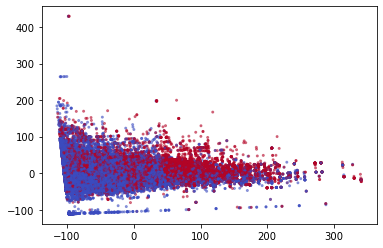

Epoch 1/200
335/335 [==============================] - 4s 4ms/step - loss: 0.6049 - accuracy: 0.6934
Epoch 2/200
335/335 [==============================] - 1s 4ms/step - loss: 0.5338 - accuracy: 0.7450
Epoch 3/200
335/335 [==============================] - 1s 4ms/step - loss: 0.5158 - accuracy: 0.7591
Epoch 4/200
335/335 [==============================] - 1s 4ms/step - loss: 0.5070 - accuracy: 0.7632
Epoch 5/200
335/335 [==============================] - 1s 4ms/step - loss: 0.5024 - accuracy: 0.7645
Epoch 6/200
335/335 [==============================] - 1s 4ms/step - loss: 0.4962 - accuracy: 0.7663
Epoch 7/200
335/335 [==============================] - 1s 4ms/step - loss: 0.4949 - accuracy: 0.7656
Epoch 8/200
335/335 [==============================] - 1s 4ms/step - loss: 0.4896 - accuracy: 0.7686
Epoch 9/200
335/335 [==============================] - 1s 4ms/step - loss: 0.4886 - accuracy: 0.7702
Epoch 10/200
335/335 [==============================] - 2s 5ms/step - loss: 0.4845 - accura

In [352]:
if __name__ == "__main__":
    main()